# Goal: Fine tune a LLM model on an instruction dataset

This notebook needs to be completed. There are placeholders for each of the following tasks which need to be coded up. Finally, this notebook should be runnable on a free Google colab instance in few minutes.

## Concrete tasks:
1. Load the instruction fine-tuning dataset
2. Load the model and tokenizer
3. Prompt the model with few items from the dataset and print the generated responses using the provided `generate()` function
4. Implement a trainer class that takes the model, dataset as inputs and
  - Instantiates necessary training components such as optimizer, learning rate scheduler etc.
  - Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective
5. Modify the `generate()` function to implement the generation logic directly using `model.forward()`. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.
6. **Plot the effect of training data on the validation loss**: The idea is to vary the amount of data used for training data (e.g. 100, 200, 500, 1000 data points) and understand its effect on the valiation loss. Please provide an explanation along with the plot. 
7. **Applying Chat template**: Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model.

Bonus points:
- You are free to use any model. But if you use a larger model (e.g. Llama model 7-B) and make it trainable on Google Colab with T4 instance in couple of minutes, it is a bonus point.
Hint: you should use techniques such **LoRA/QLoRa** to reduce the number of trainable parameters, use **quantization** to reduce the memory requirements.
- Optimize the `generate()` further to use attention key-value caching. The idea is that we do not want to recompute attention values for our prompt at every decoding step.

# Install Dependencies
If you add any new depencies, make sure to update the following cell accordingly.

In [1]:
# !!pip install -q accelerate==0.21.0 peft==0.4.0 transformers==4.36.2 bitsandbytes==0.40.2 datasets

# Imports
All imports should be added below.

In [2]:
from datasets import load_dataset
from transformers import AutoModel, AutoTokenizer, AutoModelForCausalLM, BitsAndBytesConfig, pipeline
import torch
from huggingface_hub import notebook_login

/raid/divyansh.rajput/.conda/envs/collinear/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/raid/divyansh.rajput/.conda/envs/collinear/lib/python3.11/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/raid/divyansh.rajput/.conda/envs/collinear/lib/python3.11/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(


## 1. Load the instruction fine-tuning dataset


In [3]:
from datasets import load_dataset

dataset = load_dataset("yizhongw/self_instruct")

/raid/divyansh.rajput/.conda/envs/collinear/lib/python3.11/site-packages/datasets/load.py:1461: FutureWarning: The repository for yizhongw/self_instruct contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/yizhongw/self_instruct
You can avoid this message in future by passing the argument `trust_remote_code=True`.
Passing `trust_remote_code=True` will be mandatory to load this dataset from the next major release of `datasets`.
  warnings.warn(


In [4]:
dataset["train"] = dataset['train'].select(range(int(0.9 * len(dataset["train"]))))
dataset["test"] = dataset["train"].select(range(int(0.9 * len(dataset["train"])), len(dataset["train"])))

In [5]:
dataset

DatasetDict({
    train: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 74350
    })
    test: Dataset({
        features: ['prompt', 'completion'],
        num_rows: 7435
    })
})

## 2. Load model and tokenizer

In [6]:
################################################################################
# bitsandbytes parameters
################################################################################

# Activate 4-bit precision base model loading
use_4bit = True

# Compute dtype for 4-bit base models
bnb_4bit_compute_dtype = "float16"

# Quantization type (fp4 or nf4)
bnb_4bit_quant_type = "nf4"

# Activate nested quantization for 4-bit base models (double quantization)
use_nested_quant = False

In [7]:
# Load tokenizer and model with QLoRA configuration
compute_dtype = getattr(torch, bnb_4bit_compute_dtype)

bnb_config = BitsAndBytesConfig(
    load_in_4bit=use_4bit,
    bnb_4bit_quant_type=bnb_4bit_quant_type,
    bnb_4bit_compute_dtype=compute_dtype,
    bnb_4bit_use_double_quant=use_nested_quant,
)

# Load the entire model on the GPU 0
device_map = {"": 4}

# Check GPU compatibility with bfloat16
if compute_dtype == torch.float16 and use_4bit:
    major, _ = torch.cuda.get_device_capability()
    if major >= 8:
        print("=" * 80)
        print("Your GPU supports bfloat16: accelerate training with bf16=True")
        print("=" * 80)

# The model that you want to train from the Hugging Face hub
# model_name = "meta-llama/Llama-2-7b-hf"
model_name = "Writer/palmyra-small"

# Load base model
model = AutoModelForCausalLM.from_pretrained(
    model_name,
    quantization_config=bnb_config,
    device_map=device_map,
)
model.config.use_cache = False
model.config.pretraining_tp = 1

# Load tokenizer
tokenizer = AutoTokenizer.from_pretrained(model_name, trust_remote_code=True)
# tokenizer.pad_token = tokenizer.eos_token
tokenizer.pad_token = tokenizer.unk_token
#tokenizer.padding_side = "right" # Fix weird overflow issue with fp16 training

Your GPU supports bfloat16: accelerate training with bf16=True


In [8]:
tokenizer.special_tokens_map

{'bos_token': '<|endoftext|>',
 'eos_token': '<|endoftext|>',
 'unk_token': '<|endoftext|>',
 'pad_token': '<|endoftext|>'}

In [9]:
model

GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=T

##  Prompt the model with few items from the dataset

In [10]:
# sentences = ["what is machine ", "how are you ", "tell me who are you "]
sentences = [dataset['train'][i]['prompt'] for i in range(3)]
input_ids = tokenizer(sentences, return_tensors='pt', padding=True, truncation=True)
input_ids = input_ids.input_ids.clone().to(model.device)
with torch.inference_mode():
    generated_ids = model.generate(input_ids, use_cache=True,max_new_tokens = 3)
    
generated_sentences = tokenizer.batch_decode(generated_ids, skip_special_tokens=True)

for i in range(len(sentences)):
    print(f"Input prompt: {sentences[i]}")
    print(f"Generated: {generated_sentences[i]}")
    print("******"*10)

/raid/divyansh.rajput/.conda/envs/collinear/lib/python3.11/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
A decoder-only architecture is being used, but right-padding was detected! For correct generation results, please set `padding_side='left'` when initializing the tokenizer.


Input prompt: Make a list of 10 ways to help students improve their study skills.

Output:
Generated: Make a list of 10 ways to help students improve their study skills.

Output:



************************************************************
Input prompt: Task: Find out what are the key topics in the document? output "topic 1", "topic 2", ... , "topic n".

The United States has withdrawn from the Paris Climate Agreement.


Generated: Task: Find out what are the key topics in the document? output "topic 1", "topic 2",..., "topic n".

The United States has withdrawn from the Paris Climate Agreement.

Q:

************************************************************
Input prompt: Given a list of numbers, find out if they are prime or not. you can answer "prime" or "not prime".

Input: List: 1, 4, 6, 8, 9

Output:
Generated: Given a list of numbers, find out if they are prime or not. you can answer "prime" or "not prime".

Input: List: 1, 4, 6, 8, 9

Output: List: 1
***********************

##  Implement your own generation logic

Modify the `generate()` function to implement the generation logic directly using `model.forward()` instead of using pipeline API. At each generation step, generated tokens are fed as inputs until the stopping condition is met (EOS is generated or max_tokens is reached). Most importantly, make sure that the generations are batched.

Bonus Point:
- Optimize the `generate()` further to use attention key-value caching.

In [11]:
class Generator():
    def __init__(self, model, tokenizer):
        super().__init__()
        self.model = model
        self.tokenizer = tokenizer

    def generate(self, texts, max_tokens=1, past_key_value=None):
        if isinstance(texts, str):
            texts = [texts]

        input_ids = self.tokenizer(texts, return_tensors='pt', padding=True, truncation=True) ## Give input ids and attention mask
        generated_tokens = input_ids.input_ids.clone().to(model.device) # Initialize with input tokens
        prompt_len = input_ids.input_ids.shape[-1]

        while True:
            # forward function give logits and pasy key value pair
            outputs = self.model.forward(input_ids=generated_tokens.to(self.model.device), 
                                          past_key_values=past_key_value,
                                          use_cache=True,
                                          return_dict=True)
            past_key_value = outputs.past_key_values
            # print(outputs.logits.shape) ### (batch_size,generated_tokens,vocab_size)
            next_token = self.get_greedy(outputs.logits)

            # print(next_token.shape). ### (batch_size,1,vocab_size)
            generated_tokens = torch.cat([generated_tokens, next_token], dim=-1)  ## (batch_size,generated_tokens,vocab_size)
            
            if (next_token == self.tokenizer.eos_token_id).all() or (generated_tokens.size(1)-prompt_len) >= max_tokens: ##till max tokens reach or all ended with eos_token
                break
        generated_tokens = self.get_decode(generated_tokens)
        return generated_tokens

    def get_greedy(self,logits):
        logits = logits[:, -1, :] ### -1 because taking last token and we have already calculates token for past value
        next_token = logits.argmax(dim=-1).unsqueeze(-1)  ## add dimension at -1
        return next_token

    def get_decode(self,generated_tokens):
        return self.tokenizer.batch_decode(generated_tokens)


In [12]:

gen = Generator(model, tokenizer)
a = gen.generate(sentences,max_tokens=10)
a

['Make a list of 10 ways to help students improve their study skills.\n\nOutput:<|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|>\n\n\n\n\n\n\n\n\n\n',
 'Task: Find out what are the key topics in the document? output "topic 1", "topic 2",..., "topic n".\n\nThe United States has withdrawn from the Paris Climate Agreement.\n\n<|endoftext|><|endoftext|><|endoftext|>Q:\n\nHow to get the value of',
 'Given a list of numbers, find out if they are prime or not. you can answer "prime" or "not prime".\n\nInput: List: 1, 4, 6, 8, 9\n\nOutput: List: ListGiven a list of numbers, find']

##  Implement a trainer class
- The class must take model, dataset and instantiates necessary training components such as optimizer, learning rate scheduler etc.
- Specifically, implement the `train()` function that performs the classic train loop with a next-token prediction objective

```
trainer = Trainer(model, dataset, train_args, ...)
trainer.train()
```

Bonus Point: Use techniques such LoRA/QLoRa to reduce the number of trainable parameters, use quantization to reduce the memory requirements.

In [22]:
import tokenize
from torch.utils.data import Dataset

class PromptResponseDataset(Dataset):
    ## Here we need to create input and output for supervised fine tuning
    ## input: prompt + completion
    ## output: padding(on the prompt length) + completion
    ## Because we need to backpropagate on the basis of completion not on the basis on prompt
    
    def __init__(self, dataset,tokenizer,type="train",max_prompt_len=128,max_response_len=512,prompt_col_name='prompt',response_col_name='completion'):
        self.prompts = prompt_col_name
        self.responses = response_col_name
        self.dataset = dataset[type]
        self.tokenizer = tokenizer
        self.tokenizer.pad_token = tokenizer.eos_token
        self.max_prompt_len = max_prompt_len
        self.max_response_len = max_response_len

    def tokenize_data(self, text, max_len, padding):
        if padding == "left":  ### we need to left pad the input prompt
            self.tokenizer.padding_side='left'
            return self.tokenizer(
                text,
                max_length=max_len, 
                padding='max_length',  # Padding to the left
                truncation=True, 
                return_tensors='pt'
            )
        elif padding == "right":  ### we need to right pad the input prompt
            self.tokenizer.padding_side='right'
            return self.tokenizer(
                text+self.tokenizer.eos_token,
                max_length=max_len, 
                padding='max_length',  # Padding to the right
                truncation=True, 
                return_tensors='pt',
                add_special_tokens = False
            )
        else:
            raise ValueError(f"Invalid padding strategy: {padding}. Please select one of ['left', 'right'].")
    
    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        prompt = self.tokenize_data(self.dataset[idx][self.prompts],self.max_prompt_len,padding="left") ##(1,seq_len)
        # print(f"prompt.shape: {prompt.size()}")
        response = self.tokenize_data(self.dataset[idx][self.responses],self.max_response_len,padding="right")
        # print(f"response.shape: {response.size()}")
        
        input_ids = torch.cat((prompt.input_ids, response.input_ids), dim=1)[:,:-1]
        attention_mask = torch.cat((prompt.attention_mask, response.attention_mask), dim=1)[:,:-1]
        label_attention_mask = torch.cat((torch.zeros_like(prompt.attention_mask), response.attention_mask), dim=1)
        # print(f"input_ids.shape: {input_ids.size()}, label_attention_mask.shape: {label_attention_mask.size()}")
        
        labels = torch.cat((prompt.input_ids, response.input_ids), dim=1)[:,1:]  ## for next word prediction
        labels[label_attention_mask[:,1:] == 0] = -100  # Setting tokens with padding to -100 (ignore index)
        # print(f"input.shape: {input_ids.size()} and labels.shape: {labels.size()}")
        return input_ids.squeeze(), labels.squeeze() ## eliminate dim=0 as it is always (1,vocab_size)


In [23]:
from torch.utils.data import DataLoader

train_loader = DataLoader(PromptResponseDataset(dataset,tokenizer,type="train"), batch_size=4)
test_loader = DataLoader(PromptResponseDataset(dataset,tokenizer,type="test"), batch_size=4)

In [24]:
for batch in train_loader:
    print("Train")
    prompts, responses = batch
    print("Prompts shape:", prompts.shape)
    print("Responses shape:", responses.shape)
    break  # Break after processing the first batch

for batch in test_loader:
    print("Test")
    prompts, responses = batch
    print("Prompts shape:", prompts.shape)
    print("Responses shape:", responses.shape)
    break  # Break after processing the first batch

Train
Prompts shape: torch.Size([4, 639])
Responses shape: torch.Size([4, 639])
Test
Prompts shape: torch.Size([4, 639])
Responses shape: torch.Size([4, 639])


In [25]:
import time
import torch
import logging
import warnings
class Trainer:
    def __init__(
        self, model, criterion, optimizer):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        
        self.train_loss_ = []
        self.val_loss_ = []
        
        self.device = self.model.device
        
    def train(self,loader):
        self.model.train()
        for features,labels in loader:
            features.to(self.device)
            labels.to(self.device)
            print(f"shape of input: {features.shape}")
            print(f"shape of input: {labels.shape}")
            
            out = self.model(features)['logits']
            
            loss = self.compute_loss(out,labels)
            self.train_loss_.append(loss.item())
            
            self.optimizer.zero_grad()
            
            loss.backward()
            
        return loss.item()
    
    # def compute_loss(self,out,labels):
    #     print(f"out.shape: {out.size()} labels:{labels.size()}")
    #     return self.criterion(out,labels)
    def compute_loss(self, logits, labels):
        logits = logits.view(-1, logits.size(-1))  # Reshape logits to 2D
        labels = labels.view(-1)   
        logits = logits.float()  # Convert logits to compatible data type
        labels = labels.long()   # labels are of integer type
        # print(f"logits.shape: {logits.size()} labels: {labels.size()}")
        # print(f"logits.type: {logits.dtype} labels: {labels.dtype}")
        # print(f"logits.view(-1, logits.size(-1): {logits.view(-1, logits.size(-1).size())} labels.view(-1): {labels.view(-1).size()}")
        return self.criterion(logits, labels)

        
    def fit(self,epochs, train_loader, val_loader=None):
        
        start_time = time.time()
        for epoch in range(epochs):
    
            train_loss = self.train(train_loader)
            self.train_loss_.append(train_loss)
            if val_loader:
                val_loss = self.evaluate(val_loader)
                self.val_loss_.append(val_loss)
            
            print(f"Time taken for epoch {epoch}: {time.time() - start_time} seconds")
        print(f"Time taken for full training: {time.time() - start_time} seconds")
        return
    
    def evaluate(self,loader):
        self.model.eval()
        with torch.no_grad():
            for features,labels in loader:
                features.to(self.device)
                labels.to(self.device)
                out = self.model(features)['logits']
                loss = self.compute_loss(out, labels)
                self.val_loss_.append(loss.item())
                
        return loss.item()
    

In [26]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
trainer = Trainer(model=model,criterion=criterion,optimizer=optimizer)

In [28]:
model.modules

<bound method Module.modules of GPT2LMHeadModel(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(2048, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Linear4bit(in_features=768, out_features=2304, bias=True)
          (c_proj): Linear4bit(in_features=768, out_features=768, bias=True)
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Linear4bit(in_features=768, out_features=3072, bias=True)
          (c_proj): Linear4bit(in_features=3072, out_features=768, bias=True)
          (act): GELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,),

In [27]:
trainer.fit(epochs=1,train_loader=train_loader,val_loader=test_loader)

shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
shape of input: torch.Size([4, 639])
s

KeyboardInterrupt: 

In [44]:
### Generating using model trained
gen = Generator(trainer.model, tokenizer)
sentences = ["what is machine learning ", "how are you ", "tell me who are you"]
a = gen.generate(sentences,max_tokens=10)
a

['what is machine learning  \nwhat is machine learning  \nwhat',
 'how are you <|endoftext|>Q:\n\nHow to get the value of',
 'tell me who are you?" "I am the one who are you?"']

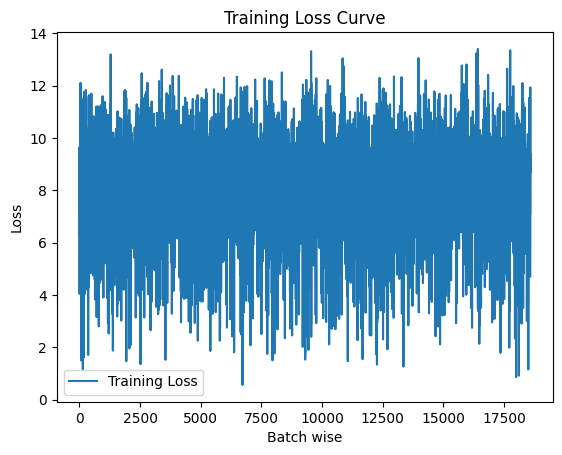

In [45]:
import matplotlib.pyplot as plt
train_loss = trainer.train_loss_
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Batch wise')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

### Training on 50 data points

In [42]:
dataset_50 = dataset.copy()
dataset_50["train"] = dataset_50['train'].select(range(50))
dataset_50["test"] = dataset_50["test"].select(range(10))
train_loader_50 = DataLoader(PromptResponseDataset(dataset_50,tokenizer,type="train"), batch_size=4)
test_loader_50 = DataLoader(PromptResponseDataset(dataset_50,tokenizer,type="test"), batch_size=4)

In [43]:
import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
trainer_50 = Trainer(model=model,criterion=criterion,optimizer=optimizer)
trainer_50.fit(epochs=1,train_loader=train_loader_50,val_loader=test_loader_50)

Time taken for epoch 0: 8.34544849395752 seconds
Time taken for full training: 8.345693588256836 seconds


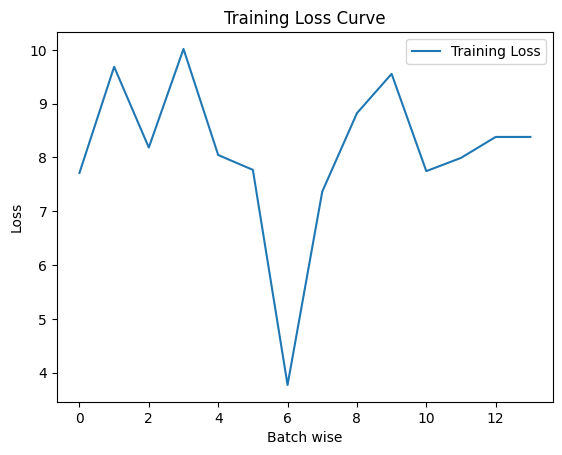

In [46]:
import matplotlib.pyplot as plt
train_loss = trainer_50.train_loss_
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Batch wise')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

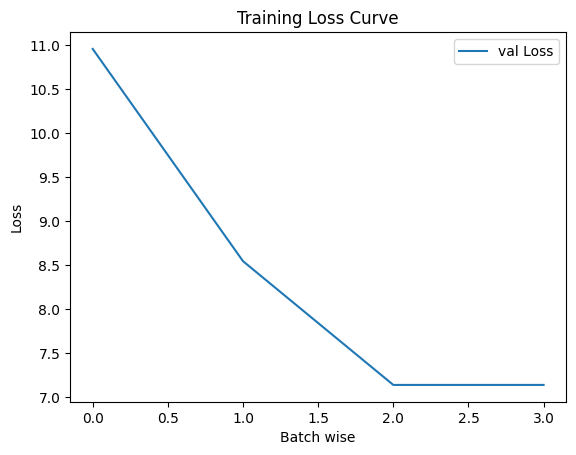

In [47]:
import matplotlib.pyplot as plt
train_loss = trainer_50.val_loss_
plt.plot(train_loss, label='val Loss')
plt.xlabel('Batch wise')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

### Training on 500 data points

In [48]:
dataset_500 = dataset.copy()
dataset_500["train"] = dataset_500['train'].select(range(500))
dataset_500["test"] = dataset_500["test"].select(range(50))
train_loader_500 = DataLoader(PromptResponseDataset(dataset_500,tokenizer,type="train"), batch_size=4)
test_loader_500 = DataLoader(PromptResponseDataset(dataset_500,tokenizer,type="test"), batch_size=4)

import torch.nn as nn
import torch.optim as optim
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters())
trainer_500 = Trainer(model=model,criterion=criterion,optimizer=optimizer)
trainer_500.fit(epochs=1,train_loader=train_loader_500,val_loader=test_loader_500)

Time taken for epoch 0: 72.96317911148071 seconds
Time taken for full training: 72.96339058876038 seconds


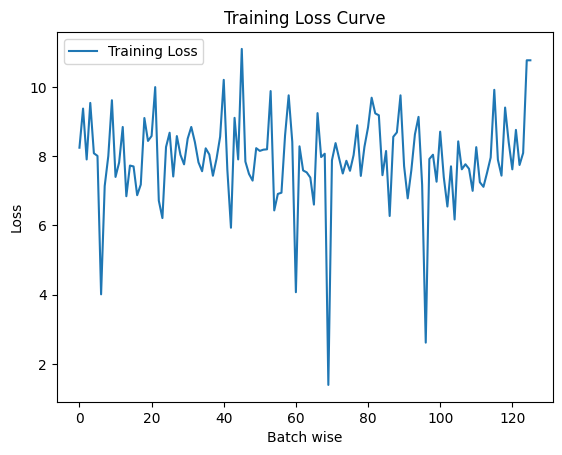

In [49]:
import matplotlib.pyplot as plt
train_loss = trainer_500.train_loss_
plt.plot(train_loss, label='Training Loss')
plt.xlabel('Batch wise')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

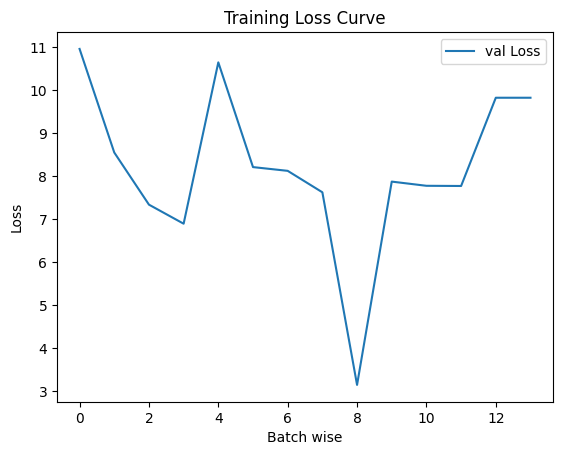

In [50]:
import matplotlib.pyplot as plt
train_loss = trainer_500.val_loss_
plt.plot(train_loss, label='val Loss')
plt.xlabel('Batch wise')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()

## 7. Applying Chat template: 
Suppose you want to switch to a different model and accordingly the prompt template needs to change. So, how would you incorporate this change without having to manually apply the template everytime you change the model?

In [32]:
chat_template = '{% for message in messages %}{{ message.content }}{{ eos_token }}{% endfor %}'
tokenizer.use_default_system_prompt = False
tokenizer.chat_template = chat_template  ## Adding ne chat template

### There are various chat template we can add on the basis of out dataset
### for mutiturn dataset we can use "{% for message in messages %}{% if message['role'] == 'user' %}{{ ' ' }}{% endif %}{{ message['content'] }}{% if not loop.last %}{{ '  ' }}{% endif %}{% endfor %}{{ eos_token }}"